  
# Trabajo Práctico 2

## Simulación de Eventos Discretos

#### Departamento de Computación - Facultad de Ciencias Exactas y Naturales - Universidad de Buenos Aires

24 de Noviembre de 2021

**Grupo 04:** Confalonieri, Gisela - Lucero, Emiliano
    

----

# Inicialización

Inicializamos variables de entorno

In [1]:
from pathlib import Path

SED_HOME = Path.home().joinpath('SED')

#Directorio base donde está instalado el siumulador
CDPP_DIR = SED_HOME.joinpath('CDPP_ExtendedStates-codename-Santi')

CDPP_SRC = CDPP_DIR.joinpath('src')
CDPP_EXAMPLES = CDPP_DIR.joinpath('examples')
CDPP_SCRIPTS = CDPP_DIR.joinpath('scripts')
BASE_BIN = CDPP_SRC.joinpath('bin')
CDPP_ATOMICS = CDPP_SRC.joinpath('cd++/atomics')

CDPP_EXAMPLES_CELL = CDPP_EXAMPLES.joinpath('cell-devs')
CDPP_BIN = BASE_BIN.joinpath('cd++')
DRAWLOG_BIN = BASE_BIN.joinpath('drawlog')

# Modelo conceptual

En el presente trabajo modelaremos una simplificación del funcionamiento de la toma de radiografías.

Una radiografía es una técnica diagnóstica radiológica, en la que la imagen se obtiene al exponer al receptor de imagen radiográfica a una fuente de radiación de alta energía, comúnmente rayos X o radiación gamma procedente de isótopos radiactivos. Al interponer un objeto entre la fuente de radiación y el receptor, las partes más densas aparecen con diferentes tonos dentro de una escala de grises [1]. 

Los rayos X y los rayos gamma comprenden la porción de las altas energías y cortas longitudes de onda del espectro electromagnético. Los rayos gamma y los rayos X de igual longitud de onda tienen idénticas propiedades. Características de la radiación ionizante se basan en las siguientes características de los rayos X y de los rayos gamma:

* Tienen una longitud de onda inversamente proporcional a su energía
* No tienen carga eléctrica ni tienen masa.
* En el espacio, ambos **viajan en línea recta a la velocidad de la luz.**
* **Pueden penetrar la materia; la profundidad de la penetración depende de la longitud de onda de la radiación y de la naturaleza del material que es penetrado.**
* **Son absorbidos por la materia; el porcentaje de absorción es función de la densidad y el espesor del material y de la longitud de onda de la radiación.**
* Son dispersados por la materia; la cantidad de dispersión es función de la densidad de la materia y de la longitud de onda de la radiación.
* Pueden ionizar la materia.
* Pueden exponer un film/detector por ionización.
* Pueden producir fluorescencia en ciertos materiales.
* No pueden detectarse por medio de los sentidos humanos.
[1]


<!---Los rayos X, como los rayos de la luz visible, divergen desde su fuente de emisión y cubren mayores áreas en la medida que aumenta la distancia desde la fuente. NO VAMOS A CONSIDERAR ESTO EN PRINCIPIO--->


En la medida que los fotones de alta energía pasan a través de un material, su energía decrece. Esto se conoce como **atenuación**. La teoría de atenuación dice que fotones de mayores energías viajan a través de los tejidos más fácilmente que los fotones de bajas energías (esto se relaciona mucho con el efecto fotoeléctrico)[2]. <!---La probabilidad de absorción fotoeléctrica es aproximadamente proporcional a $$(Z/E)^3$$, donde Z es el número atómico del átomo de tejido y E es la energía del fotón. A medida que E es más grande, la probabilidad de interacción cae rápidamente .--->

<!--- lo que finalmente es la "placa de radiografía" es la marca de los rayos que han logrado atravesar las partes más blandas y llegar al chasis con la placa (por eso los huesos salen blancos y los pulmones, que tienen aire, negros). 

Además, los rayos se atenúan con la distancia, por lo que cambia la cantidad de radiación necesaria según la distancia del cañón al objetivo, y la calidad de imagen que se desea obtener.--->

Entonces, en este trabajo nos interesa modelar una vista "transversal" de este proceso: simulando el disparo de fotones desde ciertos puntos en un extremo de un plano y con cierta energía inicial, su avance en el espacio en línea recta, la atenuación de su energía en la medida que recorre el aire y/o se encuentra con materiales que puedan absorber parte de la energía, y la energía con la que llegan los fotones al extremo receptor del plano, representando la imagen radiológica resultante.

Por simplicidad, no consideraremos en nuestro primer modelo los aspectos de dispersión de radiación ni divergencia desde la fuente de emisión (es decir, que los rayos cubren mayores áreas en la medida que aumenta la distancia desde la fuente). Por lo tanto, nuestro modelo sólo considerará rayos que se disparan en línea recta desde la fuente emisora hacia el extremo receptor.

![](./imgs/idea_radiografia.png)

## Estructura del modelo


* La dinámica de los fotones se modela en una grilla de celdas, comenzando en el extremo izquierdo y trasladándose hasta el extremo derecho en ángulo recto. Cada celda representa la carga energética de un haz de múltiples fotones que se comportan de manera idéntica.
* El extremo izquierdo de la grilla representa la fuente de radiación. Al comenzar la simulación, se establecen las cargas iniciales de los fotones en la primer celda de cada fila (no hay puertos de entrada).
* El extremo derecho de la grilla representa el receptor. Al llegar un haz de fotones a la última celda de cada fila, se almacena el valor correspondiente a la carga de los fotones en ese momento.
* Otra grilla modela los obstáculos con los que se encuentran los fotones en su camino. En este caso, cada celda contiene el coeficiente de atenuación dependiendo del material del objeto y la densidad del mismo.
* Mediante las reglas, se define el movimiento de los fotones en el tiempo y el cálculo de atenuación de cargas dependiendo del material que atraviesen los fotones.
* Asumimos que no hay rebotes de fotones.
* Interpretamos cada celda de ambas grillas como 1cm³ de espacio. Es decir, una grilla tendrá en sus celdas la representación de la energía de los fotones en ese cm³, y la otra grilla tendrá en sus celdas la representación del coeficiente de atenuación de un material en ese cm³.

Las siguientes imágenes representan lo descrito arriba. El tamaño de las grillas en las imágenes es a modo orientativo, ya que trabajaremos con casos de diferentes tamaños.

*Grilla de celdas con transmisión de fotones desde una fuente hasta un receptor:*

![](./imgs/grillafotones.png)

*Grilla de celdas con obstáculos que atenuarán la energía de los fotones:*

![](./imgs/grillaobstaculos.png)

## Coeficiente de atenuación lineal para rayos X

El coeficiente de atenuación lineal ($\mu$) es una constante que describe la fración de fotones atenuados en un haz monoenergético por unidad de espesor de un material. Su complemento es la porción transmitida del haz de fotones. 

El coeficiente de atenuación lineal incrementa con el número atómico y la densidad física del material absorbente, y decrementa con la energía del fotón.[4]

La intensidad del haz de rayos X se calcula utilizando la siguiente ecuación:

$I (x) = I_0 e^{-\mu x}$

donde $I$ es la intensidad luego de la atenuación, $I_0$ es la intensidad entrante y $\mu$ es el coeficiente de atenuación.[2]

Dado que este coeficiente se calcula en función de la energía de los fotones incidentes, asumimos un disparo de 100KeV en todos los casos, y utilizamos los coeficientes correspondientes a esa energía inicial. Estos coeficientes los tomamos de las tablas presentadas en [2] y [5], en este último caso convirtiendo los coeficientes de atenuación de masa en coeficientes de atenuación lineal como se especifica en [4].

La celda que representa al obstáculo almacena el coeficiente de atenuación correspondiente a su material y espesor. A cada paso de simulación, se computará la atenuación correspondiente a la incidencia de los rayos y el coeficiente de atenuación del material representado en dicha celda.

# Modelo _CellDEVS_

Este modelo no tiene puertos de entrada ni de salida, y consta sólo de un atómico Cell-DEVS para representar los haces de fotones y los materiales con los que interactúan.

Los bordes del modelo son _nowrapped_ (no circular) y se utiliza retardo de transporte, en tiempo mínimo para poder observar los cambios (ya que los fotones se desplazan a la velocidad de la luz).

## Vecindario

El vecindario comprende a las celdas que se ubican a izquierda y a derecha (si existen) de la celda actual en ambas grillas del modelo:

```
neighbors : rayos(0,-1,0)  rayos(0,0,0)  rayos(0,1,0)
neighbors : rayos(0,-1,1)  rayos(0,0,1)  rayos(0,1,1)
```



## Reglas

* **Regla avanzar sin obstáculos**
    * Si mi valor en intensidades (rayos) y en atenuaciones (material) es 0, y el valor de intensidad de mi vecino izquierdo es mayor a 0, tomo el valor de intensidad de mi vecino izquierdo.
    
```
rule : {(0,-1,0)} vel_propagacion {(0,0,0) = 0 and (0,0,1) = 0 and (0, -1, 0) > 0}  
```

* **Regla avanzar con obstáculos**
    * Si mi valor en intensidades (rayos) es 0 y en atenuaciones (material) no es 0, y el valor de intensidad de mi vecino izquierdo es mayor a 0, calculo mi intensidad según la intensidad de mi vecino izquierdo y el coeficiente de atenuacion.
    
```
rule : {(0,-1,0) * exp(-1.0 * (0,0,1))} vel_propagacion {(0,0,0) = 0 and (0,0,1) > 0 and (0, -1, 0) > 0}  
```

* **Regla ya avancé**
    * Si mi valor en intensidades (rayos) no es 0 y a mi derecha hay un valor mayor a 0, significa que el rayo ya pasó, me pongo en 0.

```
rule : {0.0} 100 {cellpos(2) = 0 and (0,0,0) > 0 and (0,1,0) > 0}
```

* **Regla borde derecho**
    * En las celdas de la última columna, se mantiene el valor 0 mientras su vecino izquierdo no tenga valor distinto de 0.
    
```
rule : {(0,0,0)} 100 {cellpos(2) = 0 and cellpos(1) = {{lastCol}} and (0, -1, 0) = 0 and (0,0,0) = 0}
```

* **Regla output**
    * En las celdas de la última columna, si su vecino izquierdo tiene un valor de intensidad mayor a 0, se toma ese valor.
    
```
rule : {(0,-1,0)} 100 {cellpos(2) = 0 and cellpos(1) = {{lastCol}} and (0, -1, 0) > 0 }
```

* **Regla default**
    * Es siempre verdadera. Mantiene el valor actual de la celda.
    
```
rule : {(0,0,0)} 0 { t }
```

## Valores iniciales

A partir de un modelo genérico, se generan modelos particulares que varían en su dimensión, y en los objetos que se encuentren en el camino. 

El modelo genérico es el siguiente:

In [2]:
%%bash -s "$CDPP_EXAMPLES"

cd $1/rayos/

cat rayos_generico.ma  

[Top]
components : rayos

[rayos]
type : cell
dim : ({{n}}, {{m}}, 2)
delay : transport
border : nowrapped
neighbors : rayos(0,-1,0)  rayos(0,0,0)  rayos(0,1,0)
neighbors : rayos(0,-1,1)  rayos(0,0,1)  rayos(0,1,1)
initialValue : 0.0
initialCellsValue: {{initialCellsValues}}
localtransition : rayos-rule
defaultDelayTime : 0.0

[rayos-rule]
% Regla avanzar sin obstaculos
% Si mi valor en intensidades y en atenuaciones es 0, y el valor de intensidad de mi vecino izquierdo es mayor a 0, tomo el % valor de intensidad de mi vecino izquierdo.

rule : {(0,-1,0)} 100 {cellpos(2) = 0 and (0,0,0) = 0 and (0,0,1) = 0 and (0, -1, 0) > 0}  

% Regla avanzar con obstaculos
% Si mi valor en intensidades es 0 y en atenuaciones no es 0, y el valor de intensidad de mi vecino izquierdo es mayor a 0, % tomo el valor de intensidad de mi vecino izquierdo menos la atenuacion. (TODO: Hacer bien el calculo de atenuacion)

rule : {(0,-1,0) * exp(-1.0 * (0,0,1))} 100 {cellpos(2) = 0 and (0,0,0) = 0 and (0,0,1) >

# Simulación del modelo con CD++

## Funciones auxiliares

Para la generación de estados iniciales de los casos.

In [3]:
# Coeficientes atenuacion lineal x Material para rayos de intensidad inicial de 100 KeV = 0.1 MeV
tabla_coefs = {
    "AIR": 0.000195,
    "WATER": 0.167,
    "CARBON": 0.335,
    "ALUMINIUM": 0.435,
    "IRON": 2.72,
    "COPPER": 3.8,
    "LEAD": 59.7,
    "LUNG_TISSUE": 0.177975,
    "SKELETAL": 0.177765,
    "SOFT_TISSUE": 0.1693,
}

COEF_AIRE = tabla_coefs["AIR"]

# Crear un archivo .val con los estados iniciales de las celdas para el caso mxn
def generar_estado_inicial(n, m, path, obstaculos=None, coef_default=0.1, val_default=1.0):
    # n = Valor de cantidad de columnas
    # m = Valor de cantidad de filas
    # path = filename del .val resultante
    # obstaculos = matriz que contiene obstaculos y sus coeficientes de atenuacion
    # coef_default = valor por defecto de los coeficientes no definidos en obstaculos
    # val_default = valor intensidad por defecto, aplica sobre la primer columna nomas
    valoresmapainicial = []
    with open("rayos/"+path+".val", 'w') as f:
        for i in range(0,m):
            for j in range(0,n):
                if len(valoresmapainicial) <= j:
                    valoresmapainicial.append([])
                for c in range(0,2):
                    if c == 0:
                        if i == 0:
                            # Los de la primer columna de rayos valen val_default
                            val = val_default
                        else:
                            # El resto de las celdas de rayos vale 0.0
                            val = 0.0
                        valoresmapainicial[j].append(val)
                    else:
                        if obstaculos is None:
                            # En todos los obstaculos pongo coef_default de atenuacion
                            val = coef_default
                        else:
                            try:
                                val = obstaculos[j][i]
                            except KeyError:
                                val = coef_default
                            except IndexError:
                                val = coef_default
                    f.write(f"({j},{i},{c}) = {val}\n")
    return valoresmapainicial
                        

# Instancia rayos_generico.ma con los valores provistos
def generar_ma(n, m, nombre_caso, initialCellsValues):
    # n = Valor de cantidad de columnas
    # m = Valor de cantidad de filas
    # nombre_caso = filename del ma resultante
    # initialCellsValues = Archivo de donde cargar los valores iniciales
    with open("rayos/rayos_generico.ma", 'r') as f:
        data = f.read()
        data = data.replace("{{n}}", str(n))
        data = data.replace("{{m}}", str(m))
        data = data.replace("{{lastCol}}", str(n-1))
        data = data.replace("{{initialCellsValues}}", initialCellsValues+".val")

    with open(f"rayos/"+nombre_caso+".ma", 'w') as f:
        f.write(data)

Para graficar la evolución del modelo

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from matplotlib import colors
import numpy as np
import os
import pandas as pd
import imageio

# definimos los nombres de las columnas en los dataframes de pandas
TIME_COL = 'time'
PORT_COL = 'port'
VALUE_COL = 'value'
MESSAGE_TYPE_COL = 'message_type'
MODEL_ORIGIN_COL = 'model_origin'
MODEL_DEST_COL = 'model_dest'
ani = None

def parse_logs():
    # valores iniciales
    # data = valoresmapainicial

    # valores que arroja cada paso de simulacion
    LOG_FILENAME = str(CDPP_EXAMPLES)+"/rayos/log.log01"

    parsed_logs = pd.read_csv(LOG_FILENAME,
                               delimiter=r' /\s+',
                               engine='python',  # C engine doesnt work for regex
                               #converters=df_converters,
                               names=[0, 1,  # Not sure what first two cols are
                                      MESSAGE_TYPE_COL,
                                      TIME_COL,
                                      MODEL_ORIGIN_COL,
                                      PORT_COL,
                                      VALUE_COL,
                                      MODEL_DEST_COL]
                              )

    # me quedo con los tiempos en un arreglo
    ats = parsed_logs.loc[parsed_logs[MESSAGE_TYPE_COL] == "@",TIME_COL]
    tiempos = np.unique(ats.to_numpy())[1:]
    
    return parsed_logs, tiempos

def draw_each_state(parsed_logs, tiempos, estado_inicial, output_filename):
    def transformar_a_coordenadas(s):
        return s.split('(')[1][:-1]

    estado = estado_inicial
    
    # dibujamos el estado inicial
  #  cmap = colors.ListedColormap(['white','red'])
    # frames.append((plt.imshow(estado, cmap=cmap, interpolation='nearest'),))
    plt.imshow(estado, cmap='YlOrRd', interpolation='nearest',vmin=0.0, vmax=1.0)
    plt.savefig('inicial.png')
    plt.close()
    
    # para cada tiempo en el que hubo cambios en las celdas, levanto los dataframes asociados a esos cambios
    filenames = ['inicial.png']
    for t in tiempos:
        salidas = parsed_logs.loc[parsed_logs[MESSAGE_TYPE_COL] == "Y"]
        datos_t = salidas.loc[salidas[TIME_COL] == t]
        datos_grafico = pd.DataFrame({"celda": datos_t["model_origin"].apply(transformar_a_coordenadas), "valores": datos_t["value"]});
        for t in datos_grafico.itertuples():
            fil, col = [int(i) for i in t[1][:-2].split(',')]
            estado[fil][col] = float(t[2])

        # dibujamos el estado luego de los cambios efectuados
        #cmap = colors.ListedColormap(['white','red'])
        plt.imshow(estado, cmap='YlOrRd', interpolation='nearest',vmin=0.0, vmax=1.0)
            
        # create file name and append it to a list
        filename = str(t)+'.png'
        filenames.append(filename)
        
        # save frame
        plt.savefig(filename)
        plt.close()
    
    # build gif
    with imageio.get_writer(output_filename, mode='I') as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
       # plt.show()
    # Remove files
    for filename in set(filenames):
        os.remove(filename)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-2527c9wv because the default path (/home/gisela/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Matplotlib is building the font cache; this may take a moment.


## Casos de prueba

### Caso grilla 10x10 

Este es un caso básico que no tiene correlato en la realidad, sino que se trata de valores que nos permiten probar los rasgos generales del comportamiento del modelo, antes de ejecutar casos más "realistas".

Instanciamos rayos_generico.ma:

* Dimensión de la grilla: 10x10
* Valor inicial de los fotones: 100 KeV (normalizado a 1) (esto será igual para todos los casos de prueba)
* Valor inicial de los obstáculos: en posición (0,4) con coeficiente 5.0

In [5]:
# Coeficientes de obstaculos seteados por nosotros
# por ejemplo pongo en (0,4) un obstaculo de coef 5.0 (0 fila, 5 col)
obstaculos_10_10 = {0:{4: 5.0}}

valoresmapainicial = generar_estado_inicial(10, 10, "estado_10_10", obstaculos_10_10, COEF_AIRE)
CASO_10_10 = "rayos_10_10"
generar_ma(10, 10, CASO_10_10, "estado_10_10")

Creamos la carpeta de nuestro proyecto en SED y copiamos los archivos correspondientes

In [6]:
%%bash -s "$CDPP_EXAMPLES"

cp -r rayos $1/

Corremos la simulación usando el modelo instanciado previamente

In [7]:
%%bash -s "$CDPP_EXAMPLES" "$CASO_10_10"

cd $1/rayos/

# Corre el modelo
../../src/bin/cd++ -m $2.ma \
                   -l log.log \
                   -t 00:05:00:000

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from rayos_10_10.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: log.log
Output to: /dev/null
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - Precision = 5
Qu

A partir de los valores iniciales y de los archivos de log arrojados por la simulación, graficamos el desplazamiento de los rayos en cada paso.

In [8]:
parsed_logs, tiempos = parse_logs()
draw_each_state(parsed_logs, tiempos, valoresmapainicial, "rayos10x10.gif")

Mostramos la animación producida por la ejecución de la celda anterior.

![](rayos10x10.gif)

Como se observa en la animación resultante, la primera columna de la grilla contiene fotones en su máxima carga, y en la medida que avanzan se atenúan en el sector donde colocamos un obstáculo. Al extremo derecho de la grilla llegan los rayos con la mínima atenuación del aire.

### Caso de Persona

En este caso simulamos una pequeña radiografia a una parte del cuerpo de una persona.

El tamaño de la grilla es de 10 cm de alto x 50 cm de ancho, y los coeficientes de atenuación en las celdas se corresponden con tejidos esquelético, suave y muscular.

In [9]:
obstaculos = {0: {36: tabla_coefs["SOFT_TISSUE"], 37: tabla_coefs["SKELETAL"], 38: tabla_coefs["SKELETAL"], 39: tabla_coefs["SKELETAL"], 40: tabla_coefs["SKELETAL"], 41: tabla_coefs["SOFT_TISSUE"]},
              1: {37: tabla_coefs["SOFT_TISSUE"], 38: tabla_coefs["LUNG_TISSUE"], 39: tabla_coefs["SKELETAL"], 40: tabla_coefs["SKELETAL"], 41: tabla_coefs["LUNG_TISSUE"], 42: tabla_coefs["SOFT_TISSUE"]},
              2: {37: tabla_coefs["SOFT_TISSUE"], 38: tabla_coefs["LUNG_TISSUE"], 39: tabla_coefs["SKELETAL"], 40: tabla_coefs["SKELETAL"], 41: tabla_coefs["LUNG_TISSUE"], 42: tabla_coefs["SOFT_TISSUE"]},
              3: {37: tabla_coefs["SOFT_TISSUE"], 38: tabla_coefs["LUNG_TISSUE"], 39: tabla_coefs["SKELETAL"], 40: tabla_coefs["SKELETAL"], 41: tabla_coefs["LUNG_TISSUE"], 42: tabla_coefs["SOFT_TISSUE"]},
              4: {37: tabla_coefs["SOFT_TISSUE"], 38: tabla_coefs["LUNG_TISSUE"], 39: tabla_coefs["SKELETAL"], 40: tabla_coefs["SKELETAL"], 41: tabla_coefs["LUNG_TISSUE"], 42: tabla_coefs["SOFT_TISSUE"]},
              5: {37: tabla_coefs["SOFT_TISSUE"], 38: tabla_coefs["LUNG_TISSUE"], 39: tabla_coefs["SKELETAL"], 40: tabla_coefs["SKELETAL"], 41: tabla_coefs["LUNG_TISSUE"], 42: tabla_coefs["SOFT_TISSUE"]},
              6: {37: tabla_coefs["SOFT_TISSUE"], 38: tabla_coefs["LUNG_TISSUE"], 39: tabla_coefs["SKELETAL"], 40: tabla_coefs["SKELETAL"], 41: tabla_coefs["LUNG_TISSUE"], 42: tabla_coefs["SOFT_TISSUE"]},
              7: {37: tabla_coefs["SOFT_TISSUE"], 38: tabla_coefs["LUNG_TISSUE"], 39: tabla_coefs["SKELETAL"], 40: tabla_coefs["SKELETAL"], 41: tabla_coefs["LUNG_TISSUE"], 42: tabla_coefs["SOFT_TISSUE"]},
              8: {37: tabla_coefs["SOFT_TISSUE"], 38: tabla_coefs["LUNG_TISSUE"], 39: tabla_coefs["SKELETAL"], 40: tabla_coefs["SKELETAL"], 41: tabla_coefs["LUNG_TISSUE"], 42: tabla_coefs["SOFT_TISSUE"]},
              9: {36: tabla_coefs["SOFT_TISSUE"], 37: tabla_coefs["SKELETAL"], 38: tabla_coefs["SKELETAL"], 39: tabla_coefs["SKELETAL"], 40: tabla_coefs["SKELETAL"], 41: tabla_coefs["SOFT_TISSUE"]},
             }


valoresmapainicial = generar_estado_inicial(10, 50, "estado_10_50", obstaculos=obstaculos, coef_default=COEF_AIRE)
CASO_10_50 = "rayos_10_50"
generar_ma(10, 50, CASO_10_50, "estado_10_50")

Creamos la carpeta de nuestro proyecto en SED y copiamos los archivos correspondientes

In [10]:
%%bash -s "$CDPP_EXAMPLES"

cp -r rayos $1/

Corremos la simulación usando el modelo instanciado previamente

In [11]:
%%bash -s "$CDPP_EXAMPLES" "$CASO_10_50"

cd $1/rayos/

# Corre el modelo
../../src/bin/cd++ -m $2.ma \
                   -l log.log \
                   -t 00:05:00:000

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from rayos_10_50.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: log.log
Output to: /dev/null
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - Precision = 5
Qu

A partir de los valores iniciales y de los archivos de log arrojados por la simulación, graficamos el desplazamiento de los rayos en cada paso.

In [12]:
parsed_logs, tiempos = parse_logs()
draw_each_state(parsed_logs, tiempos, valoresmapainicial, "rayos10x50.gif")

Mostramos la animación producida por la ejecución de la celda anterior.

<img src="rayos10x50.gif">

Como se observa en la animación resultante, los rayos comienzan con su máxima potencia (el valor inicial de los fotones) y se van atenuando en la medida que interactúan con diversos tejidos. El tejido suave y muscular produce menos atenuación que el hueso. Finalmente, todo el haz de fotones queda atenuado debido a que en algún momento, todos los rayos atraviesan hueso.

### Caso caja de metales

En este caso, nuestro obstáculo es una caja hueca 3D compuesta de diversos metales. Las dimensiones de la caja son:

* 8 cm de alto
* 5 cm de largo
* 4 cm de ancho

Los lados de la caja son de 1 cm de espesor. Los lados son de hierro, la tapa de aluminio y el fondo de cobre.

La idea es simular sobre cortes 2D de la caja vacia.

#### Corte central

En este caso, los obstáculos representan un corte vertical en algún lugar del centro hueco de la caja.

In [13]:
obstaculos = {
              1: { 4: tabla_coefs["IRON"], 5: tabla_coefs["ALUMINIUM"], 6: tabla_coefs["ALUMINIUM"], 7: tabla_coefs["ALUMINIUM"], 8: tabla_coefs["ALUMINIUM"],9: tabla_coefs["IRON"]},
              2: { 4: tabla_coefs["IRON"], 9: tabla_coefs["IRON"]},
              3: { 4: tabla_coefs["IRON"], 9: tabla_coefs["IRON"]},
              4: { 4: tabla_coefs["IRON"], 9: tabla_coefs["IRON"]},
              5: { 4: tabla_coefs["IRON"], 9: tabla_coefs["IRON"]},
              6: { 4: tabla_coefs["IRON"], 9: tabla_coefs["IRON"]},
              7: { 4: tabla_coefs["IRON"], 9: tabla_coefs["IRON"]},
              8: { 4: tabla_coefs["COPPER"], 5: tabla_coefs["COPPER"], 6: tabla_coefs["COPPER"], 7: tabla_coefs["COPPER"], 8: tabla_coefs["COPPER"],9: tabla_coefs["COPPER"]},
             }


valoresmapainicial = generar_estado_inicial(10, 10, "estado_caja_10_10", obstaculos, coef_default=COEF_AIRE)
CASO_CAJA_10_10 = "rayos_caja_10_10"
generar_ma(10, 10, CASO_CAJA_10_10, "estado_caja_10_10")

In [14]:
%%bash -s "$CDPP_EXAMPLES"

cp -r rayos $1/

In [15]:
%%bash -s "$CDPP_EXAMPLES" "$CASO_CAJA_10_10"

cd $1/rayos/

# Corre el modelo
../../src/bin/cd++ -m $2.ma \
                   -l log.log \
                   -t 00:05:00:000

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from rayos_caja_10_10.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: log.log
Output to: /dev/null
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - Precision =

In [16]:
parsed_logs, tiempos = parse_logs()
parsed_logs_centro = parsed_logs.copy(True)
draw_each_state(parsed_logs, tiempos, valoresmapainicial, "caja10x10.gif")

Mostramos la animación producida por la ejecución de la celda anterior.

<img src="caja10x10.gif">

La animación resultante muestra cómo los bordes atenúan más que el centro, ya que son sólidos, mientras que el centro es hueco.

#### Corte Lado

Este corte representa el borde lateral de la caja.

In [17]:
obstaculos = {
              1: { 4: tabla_coefs["IRON"], 5: tabla_coefs["ALUMINIUM"], 6: tabla_coefs["ALUMINIUM"], 7: tabla_coefs["ALUMINIUM"], 8: tabla_coefs["ALUMINIUM"],9: tabla_coefs["IRON"]},
              2: { 4: tabla_coefs["IRON"], 5: tabla_coefs["IRON"], 6: tabla_coefs["IRON"], 7: tabla_coefs["IRON"], 8: tabla_coefs["IRON"], 9: tabla_coefs["IRON"]},
              3: { 4: tabla_coefs["IRON"], 5: tabla_coefs["IRON"], 6: tabla_coefs["IRON"], 7: tabla_coefs["IRON"], 8: tabla_coefs["IRON"], 9: tabla_coefs["IRON"]},
              4: { 4: tabla_coefs["IRON"], 5: tabla_coefs["IRON"], 6: tabla_coefs["IRON"], 7: tabla_coefs["IRON"], 8: tabla_coefs["IRON"], 9: tabla_coefs["IRON"]},
              5: { 4: tabla_coefs["IRON"], 5: tabla_coefs["IRON"], 6: tabla_coefs["IRON"], 7: tabla_coefs["IRON"], 8: tabla_coefs["IRON"], 9: tabla_coefs["IRON"]},
              6: { 4: tabla_coefs["IRON"], 5: tabla_coefs["IRON"], 6: tabla_coefs["IRON"], 7: tabla_coefs["IRON"], 8: tabla_coefs["IRON"], 9: tabla_coefs["IRON"]},
              7: { 4: tabla_coefs["IRON"], 5: tabla_coefs["IRON"], 6: tabla_coefs["IRON"], 7: tabla_coefs["IRON"], 8: tabla_coefs["IRON"], 9: tabla_coefs["IRON"]},
              8: { 4: tabla_coefs["COPPER"], 5: tabla_coefs["COPPER"], 6: tabla_coefs["COPPER"], 7: tabla_coefs["COPPER"], 8: tabla_coefs["COPPER"],9: tabla_coefs["COPPER"]},
             }


valoresmapainicial = generar_estado_inicial(10, 10, "estado_caja_lado_10_10", obstaculos, coef_default=COEF_AIRE)
CASO_CAJA_LADO_10_10 = "rayos_caja_lado_10_10"
generar_ma(10, 10, CASO_CAJA_LADO_10_10, "estado_caja_lado_10_10")

In [18]:
%%bash -s "$CDPP_EXAMPLES"

cp -r rayos $1/

In [19]:
%%bash -s "$CDPP_EXAMPLES" "$CASO_CAJA_LADO_10_10"

cd $1/rayos/

# Corre el modelo
../../src/bin/cd++ -m $2.ma \
                   -l log.log \
                   -t 00:05:00:000

PCD++: A Tool to Implement n-Dimensional Cell-DEVS models
Version 3.0 - March 2003
Troccoli A., Rodriguez D., Wainer G., Barylko A., Beyoglonian J., Lopez A.
-----------------------------------------------------------------------------
PCD++ Extended States: An extended and improved version of CD++ for Cell-DEVS
Version 4.1.2 - December 2018
Santi L., Castro, R., Pimás, J.
-----------------------------------------------------------------------------
Discrete Event Simulation Lab
Departamento de Computación
Facultad de Ciencias Exactas y Naturales
Universidad de Buenos Aires, Argentina
-----------------------------------------------------------------------------
Compiled for standalone simulation


Loading models from rayos_caja_lado_10_10.ma
Loading events from 
Running parallel simulation. Reading models partition from 
Model partition details output to: /dev/null*
Message log: log.log
Output to: /dev/null
Tolerance set to: 1e-08
Configuration to show real numbers: Width = 12 - Precis

In [20]:
parsed_logs, tiempos = parse_logs()
parsed_logs_lado = parsed_logs.copy(True)
draw_each_state(parsed_logs, tiempos, valoresmapainicial, "cajalado10x10.gif")

Mostramos la animación producida por la ejecución de la celda anterior.

<img src="cajalado10x10.gif">

En esta última animación, vemos cómo todo el lateral de la caja atenúa de igual manera a los rayos, ya que es todo el borde sólido, a diferencia del caso anterior donde el centro era hueco.

### Union de los outputs

Si unimos los outputs de la simulacion de los 2 lados y del centro(repetido dos veces) obtenemos

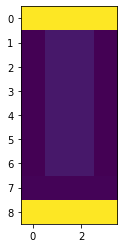

In [21]:
def datos_ultima_col(parsed, tiempos):
    def transformar_a_coordenadas(s):
        return s.split('(')[1][:-1]
    salidas = parsed.loc[parsed[MESSAGE_TYPE_COL] == "Y"]
    datos_t = salidas.loc[salidas[TIME_COL] == tiempos[-1]]
    datos_grafico = pd.DataFrame({"celda": datos_t["model_origin"].apply(transformar_a_coordenadas), "valores": datos_t["value"]})
    return datos_grafico

output_lado = [float(i) for i in list(datos_ultima_col(parsed_logs_lado, tiempos).valores)]
output_centro = [float(i) for i in list(datos_ultima_col(parsed_logs_centro, tiempos).valores)]

img = np.rot90(np.array([output_lado, output_centro, output_centro, output_lado]))
plt.imshow(img, interpolation='nearest', vmin=0.0, vmax=1.0)

# Conclusiones

En este trabajo representamos la traslación de fotones desde un tubo de rayos X hacia un receptor de radiación, calculando las atenuaciones correspondientes a los materiales con los que los rayos se van encontrando en su camino.

Si bien se trata de una gran simplificación del funcionamiento de la radiación, nos permite observar una correlación entre las simulaciones y lo que se esperaría ver en la realidad, tanto en el caso de tejidos de una parte del cuerpo como en el caso de una caja de metal.

Como trabajo futuro, se puede considerar extender este modelo a uno que represente tres dimensiones, pudiendo obtener una radiografía completa al finalizar la simulación. También podrían contemplarse otros efectos de la radiación como la dispersión de fotones, y sus efectos en el resultado final de la placa.

# Links - Referencias
[1] [Radiography - Wikipedia](https://en.wikipedia.org/wiki/Radiography)

[2] [What is X-Ray Attenuation](https://www.radiation-dosimetry.org/what-is-x-ray-attenuation-definition/)

[3] [Simulation of X-Ray NDT Imaging Techniques](https://www.ndt.net/article/wcndt00/papers/idn256/idn256.htm)

[4] [Linear attenuation coefficient](https://radiopaedia.org/articles/linear-attenuation-coefficient)

[5] [X-Ray Mass Attenuation Coefficients](https://physics.nist.gov/PhysRefData/XrayMassCoef/tab2.html)
